### Importing Essential Libraries

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

### Importing and Understanding Our Dataset

In [4]:
# Load the dataset
heart_disease = pd.read_csv('data/heart.csv')

In [ ]:
# Verifying it as a 'Dataframe' Object in Pandas
type(heart_disease)

In [ ]:
heart_disease.describe()

In [ ]:
heart_disease.info()

In [ ]:
# Shape of the Dataset
heart_disease.shape

In [ ]:
# Printing out a few columns
heart_disease.head()

### EDA

target
1    526
0    499
Name: count, dtype: int64
target
1    0.513171
0    0.486829
Name: proportion, dtype: float64


<Axes: xlabel='target', ylabel='count'>

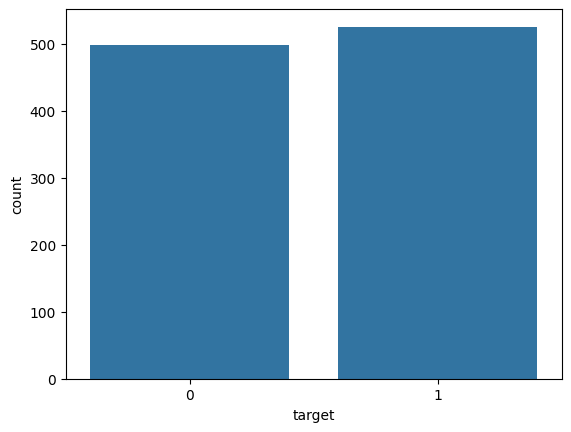

In [416]:
# Class imbalance
print(heart_disease['target'].value_counts())
print(heart_disease['target'].value_counts(normalize=True))

sns.countplot(data=heart_disease, x='target')

In [ ]:
# Numerical Distributions
numerical_cols = ['age', 'chol', 'thalach', 'oldpeak', 'ca']
n_cols = 2
n_rows = len(numerical_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
plt.subplots_adjust(hspace=0.4)

for i, col in enumerate(numerical_cols):
    # Distribution plot
    sns.histplot(heart_disease[col], kde=True, ax=axes[i][0], color='skyblue')
    axes[i][0].set_title(f'{col} Distribution')

    # Barplot vs target
    sns.barplot(x='target', y=col, data=heart_disease, ax=axes[i][1], palette='Set2', hue='target')
    axes[i][1].set_title(f'{col} vs Target')

plt.tight_layout()
plt.show()


In [ ]:
# Categorical Distributions
categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope']
n_cols = 2
n_rows = len(categorical_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
plt.subplots_adjust(hspace=0.4)

for i, col in enumerate(categorical_cols):
    # Distribution plot for categorical feature
    sns.countplot(x=col, hue=col, data=heart_disease, ax=axes[i][0], palette='pastel')
    axes[i][0].set_title(f'{col} Distribution')

    # Countplot of feature grouped by target
    sns.countplot(x=col, hue='target', data=heart_disease, ax=axes[i][1], palette='Set2')
    axes[i][1].set_title(f'{col} vs Target')

plt.tight_layout()
plt.show()


### Data preprocessing

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Numerical transfomer pipeline
numerical_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca']

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
])

In [ ]:
# Categorical transfomer pipeline
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']

categorical_transofrmer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=-1)),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [ ]:
# Data preprocessing

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transofrmer, categorical_features),
        ('num', numerical_transformer, numerical_features)
    ]
)

### Model Building

In [ ]:
X = heart_disease.drop('target', axis=1)
y = heart_disease['target']

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

In [414]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

classification_models = {
        'Logistic Regression' : Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', LogisticRegression(max_iter=1000))
        ]),
        'RandomForestClassifier' : Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', RandomForestClassifier())
        ]),
        'XGBoost' : Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', XGBClassifier())
        ])
    }

results = {}

In [415]:
np.random.seed(42)

for model_name, model in classification_models.items():
    model.fit(X_train, y_train)
    results[model_name] = model.score(X_test, y_test)

results

/home/archlinux/Desktop/TheAIEngineers/Zero-To-Mastery-ML-Notebooks/section-2-data-science-and-ml-tools/testvenv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'Logistic Regression': 0.8015564202334631,
 'RandomForestClassifier': 0.9766536964980544,
 'XGBoost': 0.9883268482490273}

<Axes: >

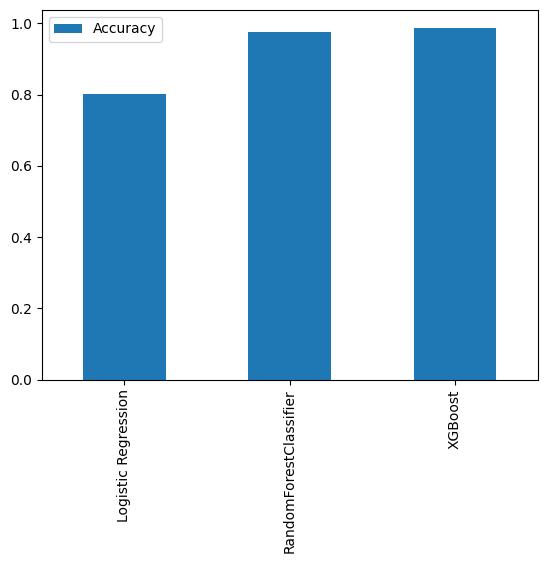

In [413]:
results_df = pd.DataFrame(results.values(),
                          results.keys(),
                          columns=['Accuracy'])
results_df.plot.bar()

# Notice that XGBoost scored the highest, with ~98.83% accuracy

## Hyperparameter Tuning

### Logistic Refression Tuning

In [ ]:
# Logistic Regression hyperparamters
log_reg_grid = {"C": np.logspace(-4, 4, 20),
                "solver": ["liblinear"]}

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

np.random.seed(42)
# Instance of RandomizedSearchCV with a LogisticRegression() estimator

rs_log_reg = RandomizedSearchCV(estimator=LogisticRegression(),
                                param_distributions=log_reg_grid,
                                cv=5,
                                n_iter=1000,
                                verbose=True)
# Fit the instance of RandomizedSearchCV
rs_log_reg.fit(X_train, y_train)

In [ ]:
# Best parameters of the RandomizedSearchCV instance
rs_log_reg.best_params_

In [ ]:
rs_log_reg.score(X_test, y_test)

In [ ]:
# LogisticRegression classifier using the best hyperparameters from RandomizedSearchCV

clf = LogisticRegression(solver='liblinear', C=11.288378916846883)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

### Random Forest Tuning

In [ ]:
# Random Forest hyperparameters
from scipy.stats import randint
rf_param_grid = {
    'n_estimators' : [100, 200],
    'max_depth' : [None , 10, 20],
    'min_samples_split' : [2, 5],
    'min_samples_leaf' : [1, 2],
    'max_features' : ['sqrt', 'log2', None],
    'bootstrap' : [True, False]
}

In [ ]:
np.random.seed(42)

rs_rf = RandomizedSearchCV(estimator=RandomForestClassifier(),
                                param_distributions=rf_param_grid,
                                cv=5,
                                n_iter=5,
                                verbose=True)
rs_rf.fit(X_train, y_train)

In [ ]:
rs_rf.best_params_

In [ ]:
rs_rf.score(X_test, y_test)

In [ ]:
# RandomForest Classifier using the best hyperparameters from RandomizedSearchCV

clf = RandomForestClassifier(n_estimators=100,
                             min_samples_split=5,
                             min_samples_leaf=1,
                             max_features='log2',
                             max_depth=None,
                             bootstrap=False)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

### XGBoost tuning

In [ ]:
# XGBoost hyperparameters

from scipy.stats import uniform
xgb_param_grid = {
    'n_estimators': randint(100, 1000),         
    'learning_rate': uniform(0.01, 0.3),       
    'max_depth': randint(3, 15),                
    'min_child_weight': randint(1, 10),        
    'subsample': uniform(0.5, 0.5),             
    'colsample_bytree': uniform(0.5, 0.5),      
    'gamma': uniform(0, 0.5),                   
    'reg_alpha': uniform(0, 1),
    'reg_lambda' : uniform(0,1)              
}

In [ ]:
np.random.seed(42)

xg_rs = RandomizedSearchCV(estimator=XGBClassifier(),
                           param_distributions=xgb_param_grid,
                           cv=5,
                           n_iter=5,
                           verbose=True)
xg_rs.fit(X_train, y_train)

In [ ]:
xg_rs.best_params_

In [ ]:
xg_rs.score(X_test, y_test)

In [ ]:
best_params = {}

clf = XGBClassifier(colsample_bytree=0.5852620618436457,
                    gamma=0.03252579649263976,
                    learning_rate=0.29466566117599996,
                    max_depth=14,
                    min_child_weight=2,
                    n_estimators=876,
                    reg_alpha=0.015966252220214194,
                    reg_lambda=0.230893825622149,
                    subsample=0.6205127330130058)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

## Model Evaluation

In [419]:
# Best scoring model is XGBoost
pipe = Pipeline([
    ('estimator', preprocessor),
    ('classifier', clf)
])
pipe.fit(X_train, y_train)

,steps,"[('estimator', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [420]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix
y_preds = pipe.predict(X_test)

In [421]:
# Confusion matrix
confusion_matrix(y_test, y_preds)

array([[132,   0],
       [  6, 119]])

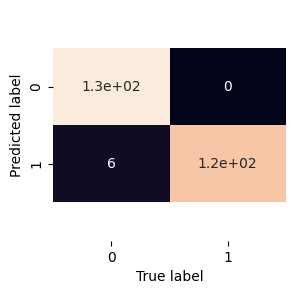

In [422]:
def plot_conf_mat(y_test, y_preds):
    """
    Plots a confusion matrix using Seaborn's heatmap().
    """
    fig, ax = plt.subplots(figsize=(3, 3))
    ax = sns.heatmap(confusion_matrix(y_test, y_preds),
                     annot=True,
                     cbar=False)
    plt.xlabel("True label")
    plt.ylabel("Predicted label")
    
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5);
    
plot_conf_mat(y_test, y_preds)

In [423]:
accuracy_score(y_test, y_preds)

0.9766536964980544

In [424]:
precision_score(y_test, y_preds)

1.0

In [425]:
recall_score(y_test, y_preds)

0.952

In [426]:
from sklearn.model_selection import cross_val_score
cross_val_acc = np.mean(cross_val_score(clf,
                                        X,
                                        y,
                                        scoring="accuracy",
                                        cv=5))

cross_val_acc

np.float64(0.9970731707317073)

In [427]:
# Cross-validated Precision
cross_val_precision = np.mean(cross_val_score(clf,
                                              X,
                                              y,
                                              scoring="precision",
                                              cv=5))

cross_val_precision

np.float64(0.9944954128440366)

In [428]:
# Cross-validated Recall
cross_val_recall = np.mean(cross_val_score(clf,
                                           X,
                                           y,
                                           scoring="recall",
                                           cv=5))

cross_val_recall

np.float64(1.0)